#Things to do for fish detection
1. data acquistion code - load the data sets into x_train, X-val, X-test
2. tensfor flow modules for NN, Convnet, Transfer model nte for Alexnet.
3. Results plotting, loss, possibly viaualising the convex optimization func


In [1]:
# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from core.classifiers.cnn import *
from core.data_utils import get_CIFAR10_data, load_fish_dataset
from core.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from core.layers import *
from core.fast_layers import *
from core.solver import Solver
import tensorflow as tf
import math
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/pushyamik/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Load the (preprocessed) CIFAR10 data.

data_fish = load_fish_dataset("/home/pushyamik/Downloads/FishDetection/RockFishDetection", subtract_mean=False)
for k, v in data_fish.items():
  print('%s: ' % k, v.shape)

X_train:  (807, 3, 90, 90)
y_train:  (807,)
X_val:  (100, 3, 90, 90)
y_val:  (100,)
X_test:  (50, 3, 90, 90)
y_test:  (50,)
mean_image:  (3, 90, 90)


In [5]:
#training the three layer convnet with fish data

model = ThreeLayerConvNet(input_dim=(3,90,90),weight_scale=0.001, hidden_dim=10,num_classes=2, reg=0.001)

solver = Solver(model, data_fish,
                num_epochs=1, batch_size=10,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 80) loss: 0.693707
(Epoch 0 / 1) train acc: 0.505576; val_acc: 0.470000
(Iteration 21 / 80) loss: 0.696076
(Iteration 41 / 80) loss: 0.696967
(Iteration 61 / 80) loss: 0.697729
(Epoch 1 / 1) train acc: 0.504337; val_acc: 0.470000


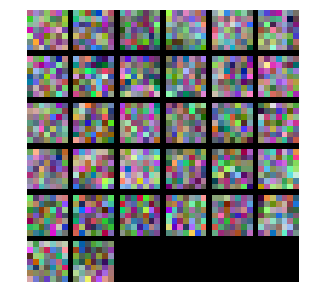

In [4]:
from core.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

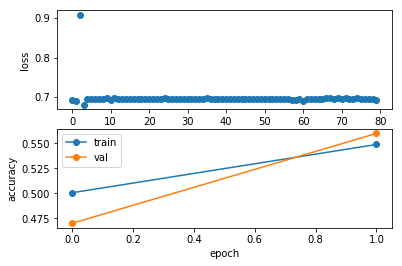

In [6]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

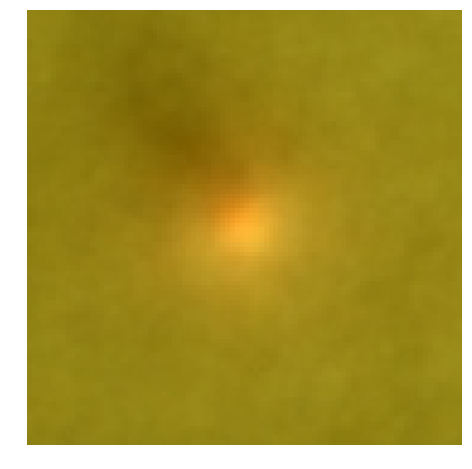

In [15]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
im = data_fish['mean_image'].transpose((1,2,0))
imshow_noax(im, normalize=True)
x_train_t = data_fish['X_train'].transpose(0,2,3,1)

#imshow_noax(x_train_t.transpose((1,2,0)), normalize=True)
#plt.title('Original image')
#n,c,h,w = data_fish['X_train'].shape
#for i in range(10):
    #x_train_t = data_fish['X_train'][i]
    #im=x_train_t[i]
    #plt.subplot(1, 10, i+1 )
    #imshow_noax(im, normalize=True)
    #plt.title(i)
    


### Training USING Tensor Flow convnets.
Current Architecture :

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs


In [14]:
# Load the (preprocessed) CIFAR10 data.

data_fish_tf = load_fish_dataset("/home/pushyamik/Downloads/FishDetection/RockFishDetection", subtract_mean=False, trans=True)
for k, v in data_fish_tf.items():
  print('%s: ' % k, v.shape)

X_train:  (807, 90, 90, 3)
y_train:  (807,)
X_val:  (100, 90, 90, 3)
y_val:  (100,)
X_test:  (50, 90, 90, 3)
y_test:  (50,)
mean_image:  (3, 90, 90)


Training
<class 'numpy.ndarray'>
[<tf.Tensor 'add_5:0' shape=<unknown> dtype=float32>, <tf.Tensor 'Equal:0' shape=(?,) dtype=bool>, <tf.Operation 'RMSProp' type=NoOp>]
Iteration 0: with minibatch training loss = 1.7 and accuracy of 0.53
Iteration 10: with minibatch training loss = 1.68 and accuracy of 0.65
Iteration 20: with minibatch training loss = 1.7 and accuracy of 0.43
Epoch 1, Overall loss = 1.7 and accuracy of 0.503


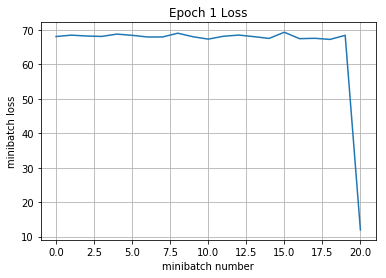

Validation
<class 'numpy.ndarray'>
[<tf.Tensor 'add_5:0' shape=<unknown> dtype=float32>, <tf.Tensor 'Equal_1:0' shape=(?,) dtype=bool>, <tf.Tensor 'Mean_2:0' shape=() dtype=float32>]
Epoch 1, Overall loss = 1.7 and accuracy of 0.5


In [20]:
def Fish_model(X,y,is_training, reg):
     #setting up variables
    
    #params for conv layer
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    
    #params or batch normalization
    scale_conv = tf.get_variable("scale_conv", shape=[84,84,32])
    offset_conv = tf.get_variable("offset_conv", shape=[84,84,32])
    
    #params for affine layer with 1024 outputs
    W1 = tf.get_variable("W1", shape=[84*84*32//4, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    
    #params for batch normalization for affine
    scale_affine = tf.get_variable("scale_affine", shape=[1024])
    offset_affine = tf.get_variable("offset_affine", shape=[1024])
    
    #params for affine layers with 10 outputs
    W2 = tf.get_variable("W2", shape=[1024, 2])
    b2 = tf.get_variable("b2", shape=[2])

    # define our graph for complex model 
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    
    #batchnormaization for conv layer
    mean_conv, var_conv = tf.nn.moments(a1, axes=[0], keep_dims=False)
    a2 = tf.nn.batch_normalization(a1, mean_conv, var_conv, offset_conv, scale_conv, 1e-6)
    
    #Relu 
    relu_1 = tf.nn.relu(a2)
    
    #max pooling
    maxpool_1 = tf.nn.max_pool(relu_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    
    #affine layer 1
    h1_flat = tf.reshape(maxpool_1,[-1,84*84*32//4])
    aff_1_out = tf.matmul(h1_flat,W1) + b1
    
    #batchnormalization for affine layer
    mean_aff1, var_aff1 = tf.nn.moments(aff_1_out, axes=[0], keep_dims=False)
    bn_aff_out = tf.nn.batch_normalization(aff_1_out, mean_aff1, var_aff1, offset_affine, scale_affine, 1e-6)
    
    #relu
    relu_2 = tf.nn.relu(bn_aff_out)
    
    #affine layer 2
    aff_2_out = tf.matmul(relu_2, W2) + b2
    
    y_out = aff_2_out
    reg_loss = tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    reg_loss *= reg
    return y_out, reg_loss
    

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 90, 90, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
reg = tf.placeholder(tf.float32)
learning_rate = 1e-3

y_out,reg_loss = Fish_model(X,y,is_training,reg)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y,2), logits=y_out)) + reg_loss
optimizer = tf.train.RMSPropOptimizer(learning_rate)


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)




def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, reg_param = 0.001):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print (type(Xd))
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    print(variables)
    
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now,
                         reg: reg_param }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,data_fish_tf['X_train'],data_fish_tf['y_train'],1,40,10,train_step,True,0.001)
        print('Validation')
        run_model(sess,y_out,mean_loss,data_fish_tf['X_val'],data_fish_tf['y_val'],1,40)